# This file process a .nc file taked from AppEARS with data from NASADEM (topography) and save it as a CSV.

### First we make explicit the installation of libraries we will use and the importing.

In [1]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj

In [2]:
import os
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd

### We create a code to know what is inside the file .nc, wich variables how many data, etc. 

In [4]:
def analyze_nasadem_file(file_path: str) -> None:
    """
    Analyze a NASADEM NetCDF file and print out its contents, such as variable names,
    dimensions, and min/max values for longitude and latitude.

    Args:
    file_path (str): The path to the NASADEM NetCDF file.
    """
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    # Open the NetCDF file
    dataset = nc.Dataset(file_path, 'r')

    # Print general information about the file
    print('')
    print(f"Analyzing file: {file_path}")
    print("Variables in this file:")
    for var in dataset.variables:
        print(f" - {var}: {dataset.variables[var].dimensions}, {dataset.variables[var].shape}")

    # Check for common variables like longitude and latitude
    if 'lon' in dataset.variables and 'lat' in dataset.variables:
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        print(f"Longitude range: {np.min(lon)} to {np.max(lon)}")
        print(f"Latitude range: {np.min(lat)} to {np.max(lat)}")
    
    # Close the dataset
    dataset.close()

# Paths to your files
file_paths = [
    '../../data/original_data/appears/nasadem/NASADEM_NC.001_30m_aid0001.nc',
]

# Analyze each file
for path in file_paths:
    analyze_nasadem_file(file_path=path)



Analyzing file: ../../data/original_data/appears/nasadem/NASADEM_NC.001_30m_aid0001.nc
Variables in this file:
 - crs: (), ()
 - time: ('time',), (1,)
 - lat: ('lat',), (2872,)
 - lon: ('lon',), (11915,)
 - NASADEM_HGT: ('time', 'lat', 'lon'), (1, 2872, 11915)
Longitude range: -17.078611111124776 to -13.769166666677682
Latitude range: 13.077222222232685 to 13.874722222233322


### After we know what its inside the file, we process him, converting into a DataFrame and saving as CSV.

In [5]:
def load_nasadem_data_to_dataframe(file_path: str) -> pd.DataFrame:
    """
    Loads NASADEM data from a NetCDF file, removes the 'time' column, 
    drops rows with NaN in 'NASADEM_HGT', and converts it to a Pandas DataFrame.

    Args:
        file_path (str): Path to the NetCDF file.

    Returns:
        pd.DataFrame: DataFrame containing the data with the modifications applied.
    """
    # Open the NetCDF file
    ds = xr.open_dataset(file_path)

    # Select the 'NASADEM_HGT' variable and the first time point
    data = ds['NASADEM_HGT'].isel(time=0)

    # Convert to DataFrame
    df = data.to_dataframe().reset_index()

    # Drop the 'time' column
    df = df.drop(columns=['time'])

    # Drop rows where 'NASADEM_HGT' is NaN
    df = df.dropna(subset=['NASADEM_HGT'])

    return df

def save_dataframe_to_csv(dataframe: pd.DataFrame, output_path: str) -> None:
    """
    Saves the given DataFrame to a CSV file.

    Args:
        dataframe (pd.DataFrame): DataFrame to be saved.
        output_path (str): Path where the CSV file will be saved.
    """
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Save the DataFrame to a CSV file
    dataframe.to_csv(output_path, index=False)


In [ ]:
# Usage
file_path = '../data/original_data/appears/nasadem/NASADEM_NC.001_30m_aid0001.nc'
output_path = '../data/processed_data/appears/nasadem/nasadem_data.csv'

df_nasadem = load_nasadem_data_to_dataframe(file_path=file_path)
save_dataframe_to_csv(dataframe=df_nasadem, output_path=output_path)

In [20]:
df_nasadem

,lat,lon,NASADEM_HGT
283,13.874722,-17.000000,0.0
284,13.874722,-16.999722,0.0
285,13.874722,-16.999444,0.0
286,13.874722,-16.999167,0.0
287,13.874722,-16.998889,0.0
...,...,...,...
34219875,13.077222,-13.770278,66.0
34219876,13.077222,-13.770000,65.0
34219877,13.077222,-13.769722,65.0
34219878,13.077222,-13.769444,64.0


### Finally we see what its inside the file to check.

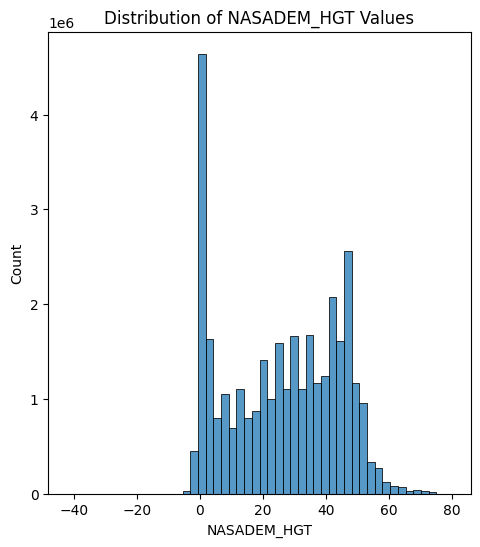

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_nasadem_hgt_distribution(df):
    """
    Plots the distribution of NASADEM_HGT values in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing NASADEM_HGT values.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Histogram of NASADEM_HGT values excluding NaNs
    plt.subplot(1, 2, 1)
    sns.histplot(df['NASADEM_HGT'].dropna(), kde=False, bins=50)
    plt.title('Distribution of NASADEM_HGT Values')
    plt.xlabel('NASADEM_HGT')
    plt.ylabel('Count')

# Call the function with your DataFrame
plot_nasadem_hgt_distribution(df_nasadem)


### In the graph above, we can see that the data in the column NASADEM_HGT looks good. A lot of values close zero means they are at the sea level. We dont see much outliers wich its a good indicator

### In the next code we will merge this data with the dataframe we have with information of the 48 wells in Gambia.

In [5]:
# read wells csv.
df_wells = pd.read_csv('../../data/processed_data/igrac/wells_gambia_final.csv')

In [6]:
df_nasadem.head()

,ID,Name,Status,Latitude,Longitude,Ground surface elevation\n,NASADEM_HGT
0,0000058001,Yoro Beri Kunda,Active,13.498482,-14.757303,17.40,18.0
1,0000035001,Pakaliba,Active,13.517245,-15.242125,13.34,17.0
2,0000024001,Somita,Active,13.208963,-16.298932,27.31,33.0
3,0000023001,Taneneh,Active,13.233057,-16.504728,14.32,18.0
4,0000020007,Mandinari OB3,Active,13.362761,-16.637219,30.47,33.0


In [7]:
df_wells.head()

,ID,Name,Latitude,Longitude,Ground surface elevation,DepthToGroundwater,Curvatu_tif2,Drainage_density,Slope_tif2,Hydrogeo
0,0000058001,Yoro Beri Kunda,13.498482,-14.757303,17.40,0-7,-1.296000e+09,88.647125,3.281346,3.0
1,0000035001,Pakaliba,13.517245,-15.242125,13.34,0-7,3.888000e+09,99.226166,3.667655,3.0
2,0000024001,Somita,13.208963,-16.298932,27.31,0-7,2.592000e+09,91.167213,0.656959,5.0
3,0000023001,Taneneh,13.233057,-16.504728,14.32,0-7,7.776000e+09,61.539433,2.500146,5.0
4,0000020007,Mandinari OB3,13.362761,-16.637219,30.47,7-25,-0.000000e+00,49.994442,1.768431,5.0


In [8]:
def merge_datasets(df_wells: pd.DataFrame, df_nasadem: pd.DataFrame, id_column: str) -> pd.DataFrame:
    """
    Merges the df_nasadem dataset into df_wells on the specified ID column, adding the NASADEM_HGT column.

    Args:
    df_wells (pd.DataFrame): DataFrame containing well data.
    df_nasadem (pd.DataFrame): DataFrame containing NASADEM data.
    id_column (str): The name of the column to join on.

    Returns:
    pd.DataFrame: The merged DataFrame.
    """
    # Merging the datasets
    merged_df = df_wells.merge(df_nasadem[[id_column, "NASADEM_HGT"]], on=id_column, how='left')
    return merged_df

# Using the function to merge the datasets
df_wells_updated = merge_datasets(df_wells=df_wells, df_nasadem=df_nasadem, id_column="ID")
df_wells_updated.to_csv('../../data/processed_data/igrac/wells_gambia_final.csv', index=False)

## Finally we have merged succesfully the data from AppEARS (nasadem) into our csv with information about the wells. 